# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Identify the input features in the used car dataset that affects the output price

Question: Based on the used car features a car price is being determined, As a Used car inventory dealer,what car feature does fetch a good price

Solution needed: Determine the top 3 features from used car inventory, that would help used car dealer to keep those inventories fetching him/her a good car price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import gc
import warnings

In [11]:
# Set up done for model evaulation and execution
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
neighbor_cnt = 5
random_value = 42
cross_validation = 5
# {The parallel_cnt value will be used in n_jobs parameter in GridSearchCV as its compute heavy 
#   '-1': to use all available CPU cores.
#    '0' or '1': Uses a single core, which is the default behavior
#    >1 : Uses the specified number of CPU cores for parallel execution}
parallel_cnt = 14

In [12]:
# Reading the cars dataset provided for evaluation into a DataFrame
cars_df = pd.read_csv('data/vehicles.csv')

In [13]:
# Check top 10 records of the DataFrame just created
cars_df.head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,7222379453,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,7221952215,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,7220195662,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,7209064557,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,7219485069,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [14]:
# Identify the null value in the dataset
cars_df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [15]:
# what is the percentage of values missing (null values) for each feature
np.round(cars_df.isnull().sum()/cars_df.shape[0] * 100, 2)

id              0.00
region          0.00
price           0.00
year            0.28
manufacturer    4.13
model           1.24
condition      40.79
cylinders      41.62
fuel            0.71
odometer        1.03
title_status    1.93
transmission    0.60
VIN            37.73
drive          30.59
size           71.77
type           21.75
paint_color    30.50
state           0.00
dtype: float64

In [16]:
#Explore the categorical features for data quality analysis
cars_df_ = cars_df.select_dtypes(exclude=['int', 'float'])
for col in cars_df_.columns:
    print('\n-----------\n')
    print('Column: :', col)
    print(cars_df_[col].nunique())
    print(cars_df_[col].sort_values().unique()) # to print categories name only
    print(cars_df_[col].sort_values().value_counts()) # to print count of every category


-----------

Column: : region
404
['SF bay area' 'abilene' 'akron / canton' 'albany' 'albuquerque'
 'altoona-johnstown' 'amarillo' 'ames' 'anchorage / mat-su' 'ann arbor'
 'annapolis' 'appleton-oshkosh-FDL' 'asheville' 'ashtabula' 'athens'
 'atlanta' 'auburn' 'augusta' 'austin' 'bakersfield' 'baltimore'
 'baton rouge' 'battle creek' 'beaumont / port arthur' 'bellingham'
 'bemidji' 'bend' 'billings' 'binghamton' 'birmingham' 'bismarck'
 'bloomington' 'bloomington-normal' 'boise' 'boone' 'boston' 'boulder'
 'bowling green' 'bozeman' 'brainerd' 'brownsville' 'brunswick' 'buffalo'
 'butte' 'cape cod / islands' 'catskills' 'cedar rapids' 'central NJ'
 'central louisiana' 'central michigan' 'champaign urbana' 'charleston'
 'charlotte' 'charlottesville' 'chattanooga' 'chautauqua' 'chicago'
 'chico' 'chillicothe' 'cincinnati' 'clarksville' 'cleveland'
 'clovis / portales' 'college station' 'colorado springs' 'columbia'
 'columbia / jeff city' 'columbus' 'cookeville' 'corpus christi'
 'corvall

Data Prep notes: Dropping the Following Features based knowledge of dataset:
*  id (This is a sequential number)
*  VIN (Unique for every car )
*  Region (State is included)
*  size (71% of data is missing)sing)

In [18]:
# Checking the Data Numerical Data Outliers and eleminating from dataset
print(cars_df.select_dtypes(include=['int', 'float']).max())
print("***************")
print(cars_df.select_dtypes(include=['int', 'float']).min())

id         7317101084.00
price      3736928711.00
year             2022.00
odometer     10000000.00
dtype: float64
***************
id         7207408119.00
price               0.00
year             1900.00
odometer            0.00
dtype: float64


Checking the Data Numerical Data Outliers: 
* Shows that there outliers in Price and odometer max values
* We need to see the distribution of these values for sample selection 

In [20]:
# Function to detect Outliers for selected feature based on IQR and provide the lower and upper bound
def outliers_filter(df, column):
    factor = 1.5
    first_quartile = df[column].quantile(.25)
    third_quartile = df[column].quantile(.75)
    iqr = third_quartile - first_quartile
    lower = first_quartile - factor*iqr
    upper = third_quartile + factor*iqr
    print( f'{ column } -> lower: { lower }, upper: { upper }')
    return

In [21]:
# Get the outliers for the price, year and odometer numerical features
outliers_filter(cars_df, 'price')
outliers_filter(cars_df, 'year')
outliers_filter(cars_df, 'odometer')

price -> lower: -24978.625, upper: 57364.375
year -> lower: 1994.5, upper: 2030.5
odometer -> lower: -106053.75, upper: 277300.25


Data Prep notes:
* 
Based on IQR values for Price we will consider the price between 0 and 70000

In [23]:
# Check the Distribution of data for odometer to determine the cut-off value for odometer to apply
final_odo_val = int(cars_df['odometer'].max())
#print(final_odo_val)
odo_per = []
odo_val = []

for i in range(100000, final_odo_val, 100000):
    inventory_per = 1-np.round(cars_df.query(f'odometer > {i}').count()/cars_df.shape[0], 4)
    odo_val.append(i)
    odo_per.append(inventory_per[0])

test = pd.DataFrame({'OdometerReading': odo_val,
                    'Percent': odo_per})
test

,OdometerReading,Percent
0,100000,0.59
1,200000,0.95
2,300000,0.99
3,400000,1.00
4,500000,1.00
...,...,...
94,9500000,1.00
95,9600000,1.00
96,9700000,1.00
97,9800000,1.00


Data Prep notes:
* Based on distribution of sample data we can consider that most of the odometer data are accounted within 500K,
* Hence we will filter out based sample records with odometer reading between '0' and '500000'

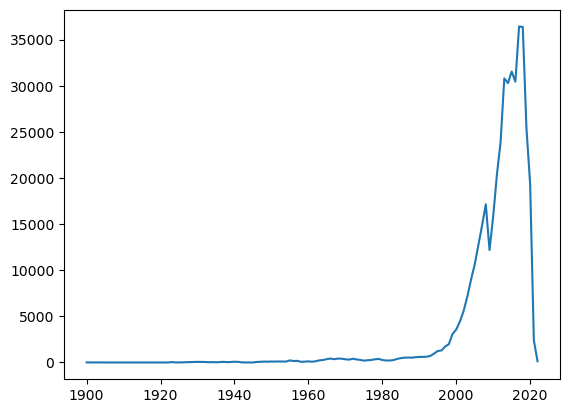

In [25]:
# Check the Distribution of data for car year to determine the cut-off value for car year to apply
inventory_year_dist = cars_df.groupby('year')['year'].count()
plt.plot(inventory_year_dist)

Data Prep Notes:
* Based on distribution of sample data we can consider that most of the car year data between '1980' and '2022'

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Applying the Data Prep Notes from Data understanding section to the cars dataset

In [29]:
# Dropping id, Vin, region(as state is taken) and size( more than 70% data missing)
cars_df = cars_df.drop(columns=['id', 'VIN','region', 'size'])

In [30]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


In [31]:
# Redefine outliers using approximated values based on suggested Data Prep Notes from Data understanding section.
# This cell will give you the reduced inventory dataset count after applying the filter
price_low = 0
price_high = 70000
price_range = ((cars_df.price > price_low) & (cars_df.price < price_high))
year_low = 1980
year_high = 2022
year_range = ((cars_df.year > year_low) & (cars_df.year < year_high))
odo_low = 0
odo_high = 500000
odo_range = ((cars_df.odometer > odo_low) & (cars_df.odometer < odo_high))
df_without_price_outliers = cars_df[price_range]
df_without_PriceYear_outliers = df_without_price_outliers[year_range]
df_without_PriceYearOdo_outliers = df_without_PriceYear_outliers[odo_range]
cars_df = df_without_PriceYearOdo_outliers.copy()
print("Data count removing outliers :  ", cars_df.shape[0])

Data count removing outliers :   377280


Below are the plots for odometer and year Vs Price without outliers

<Axes: xlabel='odometer', ylabel='price'>

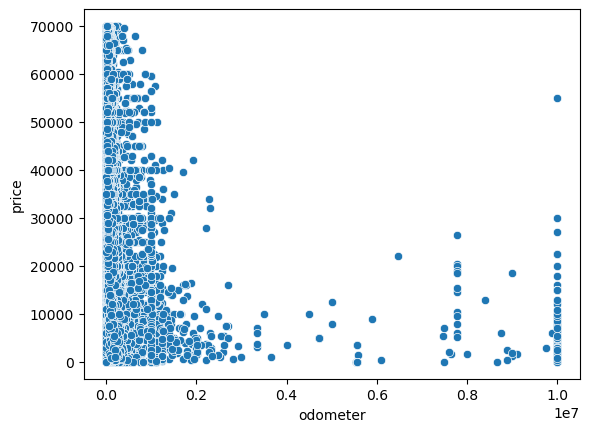

In [33]:
# Scatter plot between odometer and price
sns.scatterplot(data=df_without_price_outliers, x="odometer", y="price")

<Axes: xlabel='year', ylabel='price'>

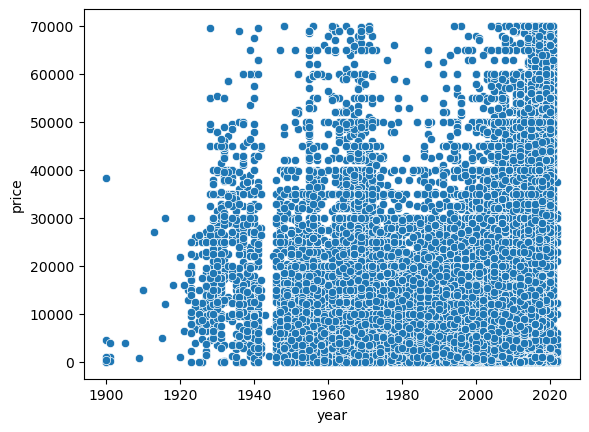

In [34]:
# Scatter plot between odometer and price
sns.scatterplot(data=df_without_price_outliers, x="year", y="price")

[Text(0.5, 1.0, ' Price Distribution')]

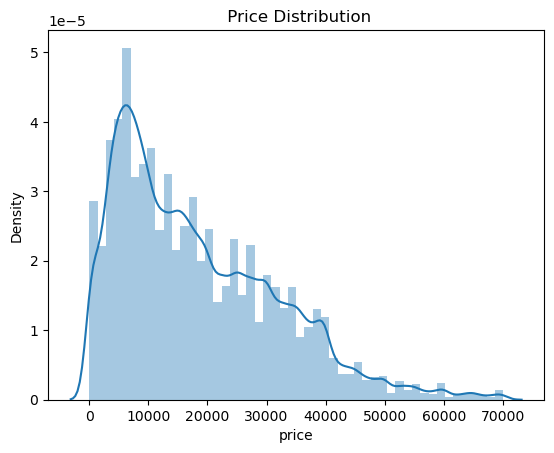

In [35]:
# Visualization to review price distributions without outliers
sns.distplot(
    cars_df['price']
).set(title = " Price Distribution")

Removing objects no longer needed from memory to free up memory for model evaluation

In [37]:
# Remove DataFrame that will not be used to free up system memory 
del [[test, inventory_year_dist, df_without_price_outliers, df_without_PriceYear_outliers, df_without_PriceYearOdo_outliers ]]
gc.collect()

213

In [38]:
# Update to whole year by removing the decimal part
cars_df['year'] = cars_df['year'].astype('int32') 

In [39]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377280 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         377280 non-null  int64  
 1   year          377280 non-null  int32  
 2   manufacturer  364936 non-null  object 
 3   model         373672 non-null  object 
 4   condition     233087 non-null  object 
 5   cylinders     223144 non-null  object 
 6   fuel          375209 non-null  object 
 7   odometer      377280 non-null  float64
 8   title_status  370426 non-null  object 
 9   transmission  375778 non-null  object 
 10  drive         262649 non-null  object 
 11  type          296995 non-null  object 
 12  paint_color   266397 non-null  object 
 13  state         377280 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(11)
memory usage: 41.7+ MB


Notes: As our dataset contain both numerical and categorical features , we need to seperate them accordingly.
We then apply the following to impute missing values
1) KNNImputer for numerical features
2) LabelEncoder for categorical features

In [41]:
# Separate features into categorical and numerical based in data types
numerical_features = np.array(cars_df.select_dtypes(include=[np.number]).columns.values).tolist()
categorical_features = np.array(cars_df.select_dtypes(include=[object]).columns.values).tolist()

In [42]:
# Function to apply Label Encoding
def label_encode(series):
    le = LabelEncoder()
    return le.fit_transform(series.fillna('Missing'))

In [43]:
# Create a KNNImputer object
numerical_transformer = KNNImputer(n_neighbors=neighbor_cnt) # KNN imputer for numerical data

In [44]:
# Impute numerical values
cars_df[numerical_features] = numerical_transformer.fit_transform(cars_df[numerical_features])

In [45]:
# Encode categorical values
for feature in categorical_features:
    cars_df[feature] = label_encode(cars_df[feature])

In [46]:
# Display the imputed DataFrame and reset index
cars_df.reset_index().drop(columns=['index'])

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590.00,2014.00,15,20602,3,6,3,57923.00,1,3,1,9,11,1
1,22590.00,2010.00,8,20949,3,6,3,71229.00,1,3,1,9,2,1
2,39590.00,2020.00,8,20994,3,6,3,19160.00,1,3,1,9,9,1
3,30990.00,2017.00,40,23695,3,6,3,41124.00,1,3,1,9,9,1
4,15000.00,2013.00,14,11978,1,5,3,128000.00,1,1,3,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377275,23590.00,2019.00,32,16610,3,5,3,32226.00,1,3,2,10,0,50
377276,30590.00,2020.00,42,19962,3,7,3,12029.00,1,3,2,10,9,50
377277,34990.00,2020.00,7,24985,3,7,1,4174.00,1,3,1,5,11,50
377278,28990.00,2018.00,24,11055,3,5,3,30112.00,1,3,2,10,10,50


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [48]:
# Create a variable to register and store MSE, MAE and R2 across multiple models evaulated
model_results = []

In [49]:
# Splitting the dataset into Train (70%) and Test (30%)
X = cars_df.drop('price', axis = 1)
y = cars_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_value)

In [50]:
# Function to evaluate and capture the model parameter and return back as dictionary
# Following paremeters are returned : MSE, MAE and R2 value for the model for both training and testing dataset.

# ---------------------------------------------------------------------------------------------#
# model_name : Name of the regression model 
# pipeline : pipeline contruct for acting on dataset
# param_grid : list of values need to evaluated for determing the hyperparameter
# hyperparam_eval : best hyperparameter to be evaluated 

def model_evaluate(model_name, pipeline, param_grid=None, hyperparam_eval=None):
    # Set up GridSearchCV
    model = ""
    if(param_grid == None):
        model = pipeline.fit(X_train, y_train)
        # Executing predictions
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
    else:
        model = GridSearchCV(pipeline, param_grid, cv=cross_validation, scoring='neg_mean_squared_error',n_jobs=parallel_cnt)
        # Fit the model using GridSearchCV
        model.fit(X_train, y_train)
        # Display the best parameters and the corresponding score
        best_param = model.best_params_[hyperparam_eval]
        best_score = model.best_score_
        print(f"Best {hyperparam_eval}: {best_param}")
        print("Best Score (Negative MSE):", best_score)
        # Prediction
        pred_train = model.best_estimator_.predict(X_train)
        pred_test = model.best_estimator_.predict(X_test)

    # MSE errors
    training_mse = mean_squared_error(y_train, pred_train)
    testing_mse = mean_squared_error(y_test, pred_test)

    # MAE errors
    training_mae = mean_absolute_error(y_train, pred_train)
    testing_mae = mean_absolute_error(y_test, pred_test)
        
    # R2 errors
    training_r2 = r2_score(y_train, pred_train)
    testing_r2 = r2_score(y_test, pred_test)

    # Reporting results for this regression model
    model_result_stats = {
    'model': model_name,
    'model_': model,
    'train_mse': training_mse,
    'test_mse': testing_mse,
    'train_mae': training_mae,
    'test_mae': testing_mae,        
    'train_r2': training_r2,
    'test_r2': testing_r2
    }
    return model_result_stats 

In [51]:
# Training the model with LinearRegression 
# (Model Name: LinearRegDeg1)
LinearRegDeg1_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
model_results.append(model_evaluate('LinearRegDeg1', LinearRegDeg1_pipeline, None, None))

In [52]:
# Create a pipeline that includes polynomial features (determine the best degree param), scaling, and a linear regression model
# (Model Name: LinearRegDeterminePFDeg ) 
LinearRegDeterminePFDeg_pipeline = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly_features__degree': [1, 2, 3]  # Test degrees 1 through 3
}

model_results.append(model_evaluate('LinearRegDeterminePFDeg', LinearRegDeterminePFDeg_pipeline, param_grid , 'poly_features__degree'))

Best poly_features__degree: 3
Best Score (Negative MSE): -58988725.93769207


In [53]:
# Create a pipeline that includes polynomial features(degree = 3), scaling, and a Lasso regression model
# (Model Name: LassoRegPFDeg3 )
LassoRegPFDeg3_pipeline = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(degree=3,include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define the parameter grid for GridSearchCV
param_grid = {'lasso__alpha': np.logspace(-2, 0, 2)}  # Exploring alpha values for 0.01 to 1

model_results.append(model_evaluate('LassoRegPFDeg3', LassoRegPFDeg3_pipeline, param_grid , 'lasso__alpha'))

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.940e+12, tolerance: 3.923e+09
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.952e+12, tolerance: 3.919e+09
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best lasso__alpha: 1.0
Best Score (Negative MSE): -66985611.603251934


In [54]:
# Create a pipeline that includes polynomial features, scaling, and a Ridge regression model
# (Model Name: RidgeRegPFDeg3 )
RidgeRegPFDeg3_pipeline = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(degree=3,include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define the parameter grid for GridSearchCV
param_grid = {'ridge__alpha': np.logspace(-4, 0, 5)}  # Exploring alpha values from 0.0001 to 1 

model_results.append(model_evaluate('RidgeRegPFDeg3', RidgeRegPFDeg3_pipeline, param_grid , 'ridge__alpha'))

Best ridge__alpha: 9.999999999999999e-05
Best Score (Negative MSE): -59440419.63460939


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [56]:
# Display the Model Evalation Result parameters
pd.DataFrame(model_results)

,model,model_,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,LinearRegDeg1,"(StandardScaler(), LinearRegression())",98930072.70,99854477.13,7348.71,7367.06,0.47,0.46
1,LinearRegDeterminePFDeg,"GridSearchCV(cv=5,\n estimator=Pip...",58600294.52,59062816.91,5190.56,5209.11,0.68,0.68
2,LassoRegPFDeg3,"GridSearchCV(cv=5,\n estimator=Pip...",66674931.78,67087126.49,5631.34,5644.39,0.64,0.64
3,RidgeRegPFDeg3,"GridSearchCV(cv=5,\n estimator=Pip...",59041753.44,59431147.85,5213.09,5232.04,0.68,0.68


Plotting each evaluated model parameters

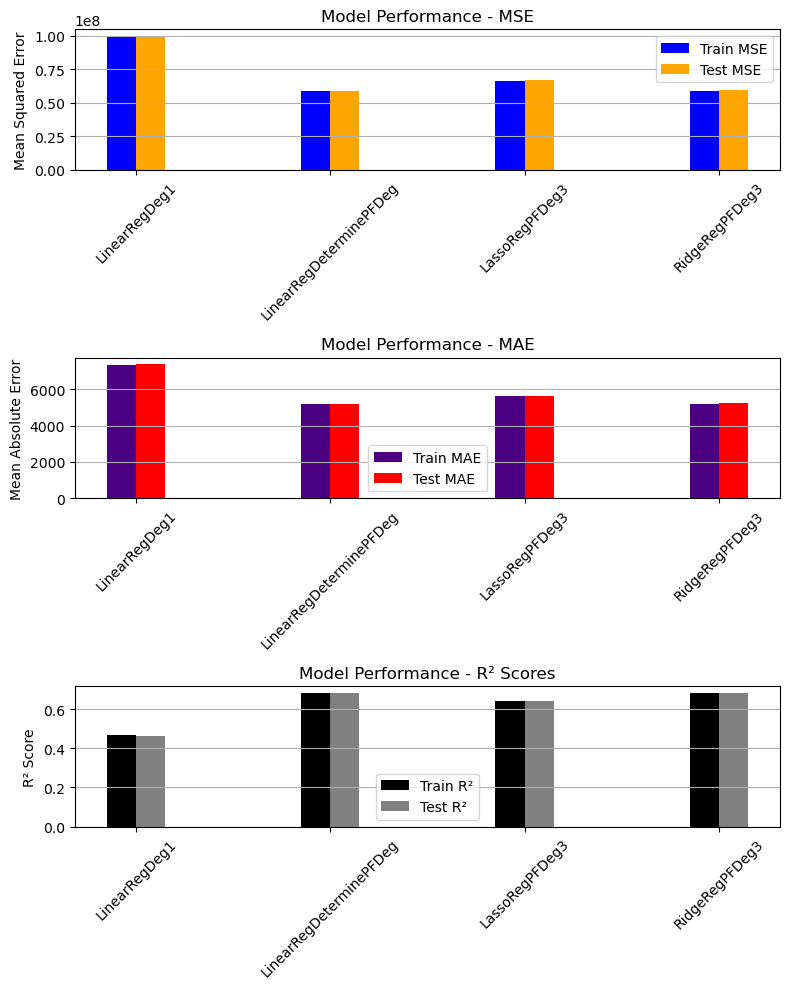

In [58]:
# Extract data for plotting
models = [entry['model'] for entry in model_results]
train_mse = [entry['train_mse'] for entry in model_results]
test_mse = [entry['test_mse'] for entry in model_results]
train_mae = [entry['train_mae'] for entry in model_results]
test_mae = [entry['test_mae'] for entry in model_results]
train_r2 = [entry['train_r2'] for entry in model_results]
test_r2 = [entry['test_r2'] for entry in model_results]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

x = np.arange(len(models))
width = 0.15

# Plot MSE scores
axs[0].bar(x - width/2, train_mse, width, label='Train MSE', color='blue')
axs[0].bar(x + width/2, test_mse, width, label='Test MSE', color='orange')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Model Performance - MSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45)
axs[0].legend()
axs[0].grid(axis='y')

# Plot MAE scores
axs[1].bar(x - width/2, train_mae, width, label='Train MAE', color='indigo')
axs[1].bar(x + width/2, test_mae, width, label='Test MAE', color='red')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].set_title('Model Performance - MAE')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45)
axs[1].legend()
axs[1].grid(axis='y')

# Plot R² scores
axs[2].bar(x - width/2, train_r2, width, label='Train R²', color='black')
axs[2].bar(x + width/2, test_r2, width, label='Test R²', color='grey')
axs[2].set_ylabel('R² Score')
axs[2].set_title('Model Performance - R² Scores')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=45)
axs[2].legend()
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

##### Understanding the feature importance computed by each of the identified model

In [60]:
# Function for output feature importance based on the model passed on to determined by GridSearchCV
def feature_selection(model_name, model_):
    result = permutation_importance(model_.best_estimator_, X_test, y_test,
                           n_repeats=10,
                           n_jobs=parallel_cnt,
                           random_state=random_value)

    # Display feature importances
    print(f"*****************{model_name}*****************")
    for i in result.importances_mean.argsort()[::-1]:
        print(f"{X_test.columns[i]:<14}, Importance: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")
    print("----------------------------------------------")  

In [61]:
# Function for plotting feature importance based on the model passed on to determined by GridSearchCV
def feature_imp_plot(model_name, model_):
    result = permutation_importance(model_.best_estimator_, X_test, y_test,
                           n_repeats=10,
                           n_jobs=parallel_cnt,
                           random_state=random_value)
    # Plot feature importances
    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]
    title = 'Permutation Feature Importance - ' + model_name
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], yerr=result.importances_std[indices], align='center')
    plt.xticks(range(len(importances)), X_test.columns[indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [62]:
# Feature Importance for each of the model execution

for m in range(1, len(models)):
    feature_selection(model_name=model_results[m]['model'], model_=model_results[m]['model_'] )

*****************LinearRegDeterminePFDeg*****************
year          , Importance: 0.421 ± 0.002
odometer      , Importance: 0.139 ± 0.001
drive         , Importance: 0.131 ± 0.001
fuel          , Importance: 0.130 ± 0.001
cylinders     , Importance: 0.104 ± 0.001
transmission  , Importance: 0.033 ± 0.000
type          , Importance: 0.022 ± 0.000
condition     , Importance: 0.021 ± 0.000
title_status  , Importance: 0.021 ± 0.001
manufacturer  , Importance: 0.014 ± 0.000
model         , Importance: 0.013 ± 0.000
paint_color   , Importance: 0.011 ± 0.000
state         , Importance: 0.005 ± 0.000
----------------------------------------------
*****************LassoRegPFDeg3*****************
odometer      , Importance: 0.265 ± 0.002
year          , Importance: 0.218 ± 0.001
drive         , Importance: 0.154 ± 0.001
fuel          , Importance: 0.117 ± 0.001
cylinders     , Importance: 0.067 ± 0.001
transmission  , Importance: 0.030 ± 0.001
type          , Importance: 0.024 ± 0.000
condit

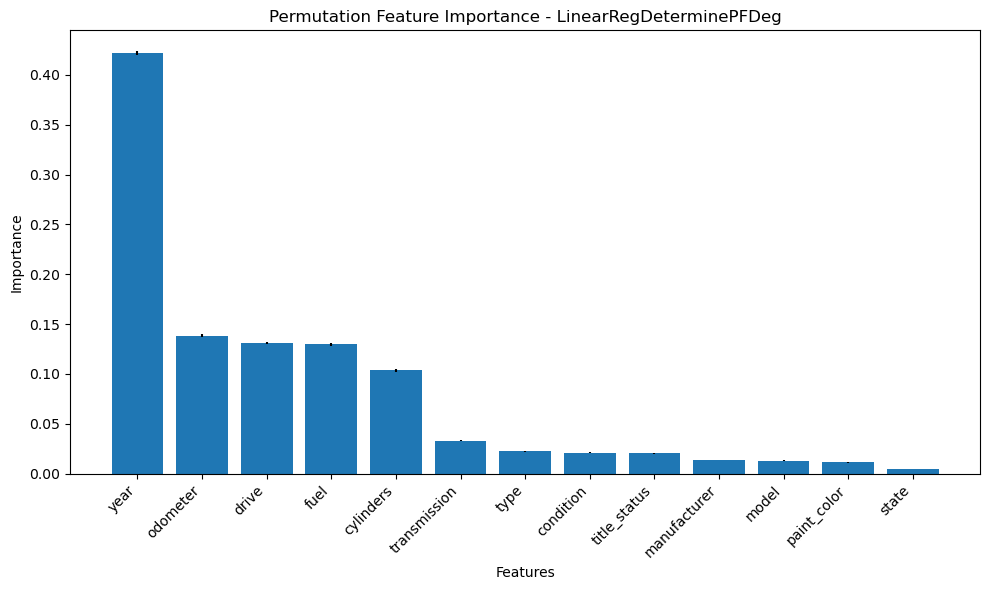

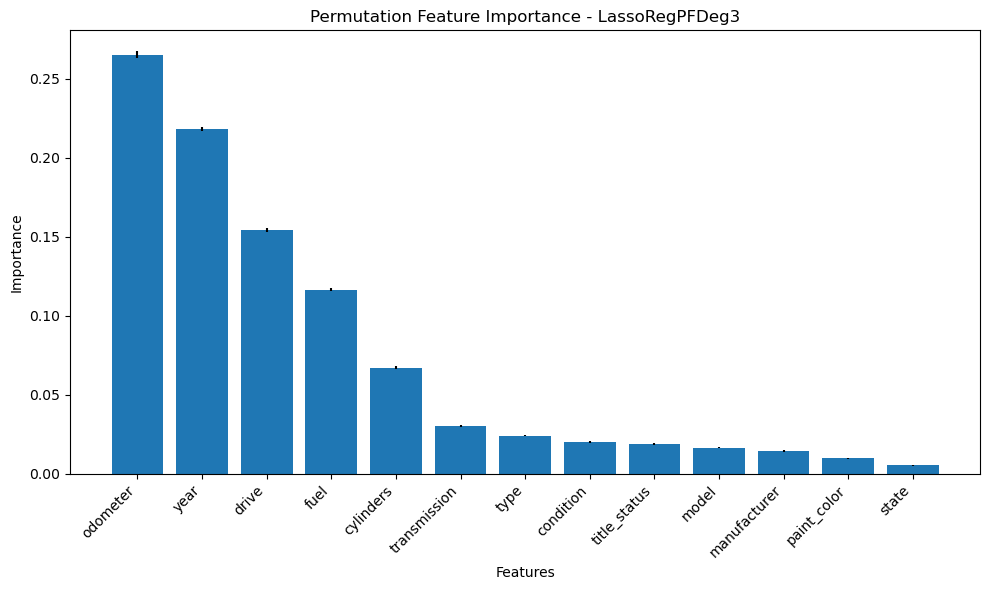

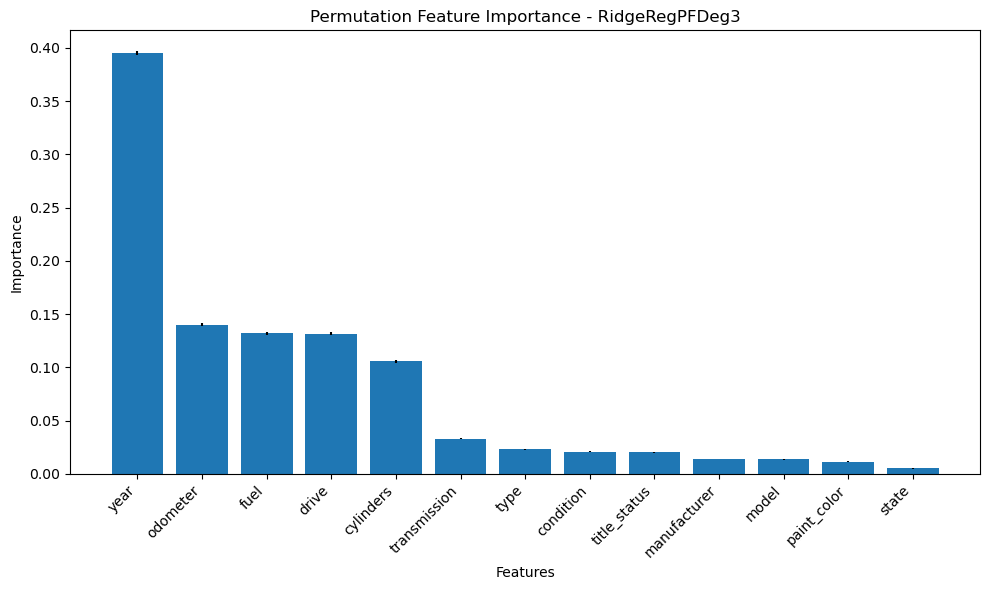

In [63]:
# Plot of Feature Importance for each of the model to determine which features were determined important in each of the model evaluated

for m in range(1, len(models)):
    feature_imp_plot(model_name=model_results[m]['model'], model_=model_results[m]['model_'] )

##### Based on the MSE, MAE and R2 score the model selection:
* The Ridge Regression model performed better in MSE,MAE, R2 scores.
* The Lasso Regression model was computationally heavy compared to Ridge.
Based on these evaulation Ridge Regression with hyperparameter alpha of "0.0001" with Polynomail feature(degree=3) would be a good choice for regression model for the used car dataset.

##### Feature selection across models:
Based on Feature Importance Plot we can see that top 5 features have more impact on the price are as follows:
1. Year
2. Odometer
3. Fuel
4. Drive
5. Cylinder

   The Year of the car does and odometer reading have high impact on the price of the car

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

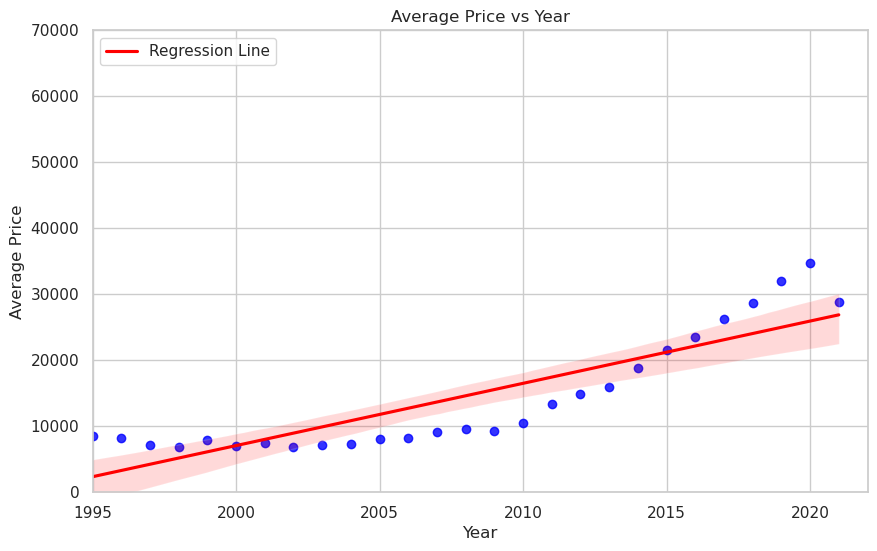

In [121]:
# Filtering for years between 1994 and 2022
df = cars_df[(cars_df['year'] >= 1994) & (cars_df['year'] <= 2022)]

# Calculating the average price by year
average_price_by_year = df.groupby('year')['price'].mean().reset_index()

# Setting the style for the plot
sns.set(style='whitegrid')

# Creating a scatter plot with a regression line using average price data
plt.figure(figsize=(10, 6))
sns.regplot(x='year', y='price', data=average_price_by_year, scatter_kws={'color': 'blue', 'label': 'Average Price'}, line_kws={'color': 'red', 'label': 'Regression Line'})

# Adding title and labels
plt.title('Average Price vs Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xlim(1995, 2022)
plt.ylim(0, 70000)

# Adding the legend
plt.legend(loc='upper left')

# Show the plot
plt.show()


Observation on Average Price and year of the car: 
* Average Price fetched by used car increases with year of the car, and car is not more than 10 years old.

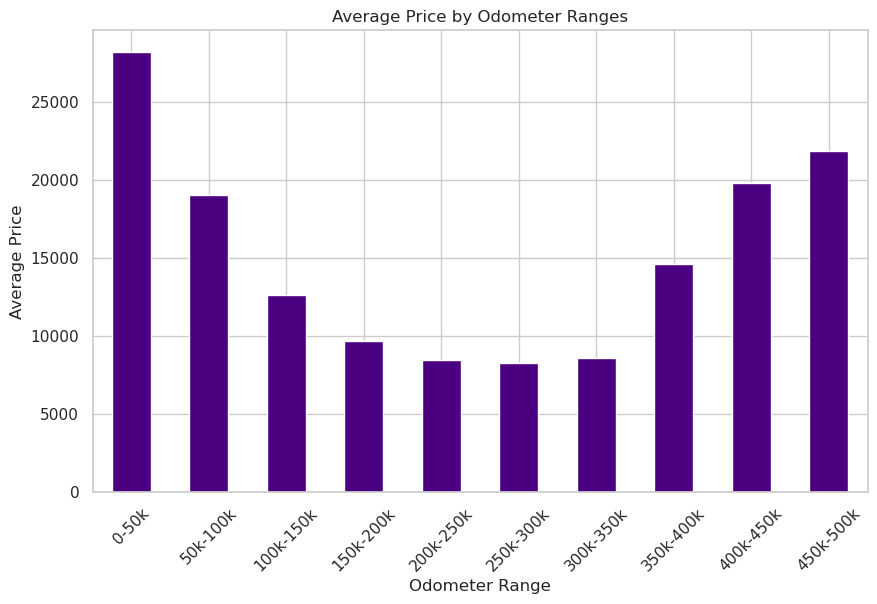

In [125]:

# Categorizing the data based on odometer readings
odometer_bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]
odometer_labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k-350k', '350k-400k', '400k-450k', '450k-500k']
df['odometer_range'] = pd.cut(df['odometer'], bins=odometer_bins, labels=odometer_labels)

# Calculating the average price by odometer range
average_price_distribution = df.groupby('odometer_range')['price'].mean()

# Plotting the bar chart for average prices
plt.figure(figsize=(10, 6))
average_price_distribution.plot(kind='bar', color='indigo')

# Adding title and labels
plt.title('Average Price by Odometer Ranges')
plt.xlabel('Odometer Range')
plt.ylabel('Average Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

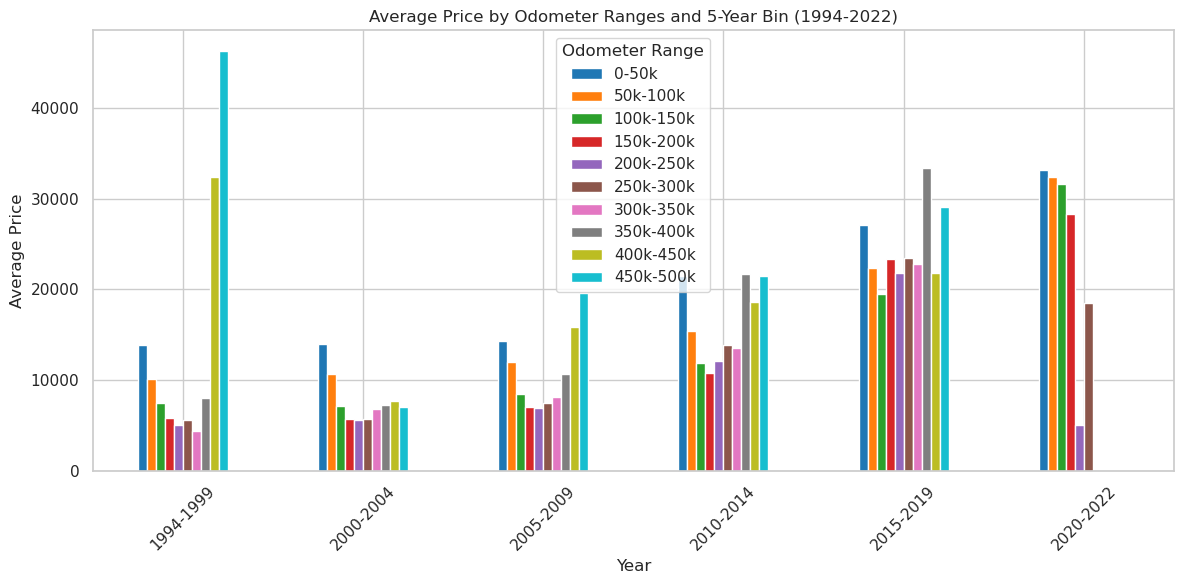

In [127]:
# Creating 5-year bins for the year
year_bins = list(range(1994, 2028, 5))  # Creates bins with 5 year increments
year_labels = ['1994-1999', '2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2022']
df['year_bin'] = pd.cut(df['year'], bins=year_bins, right=False, labels=year_labels)

# Calculating the average price by year bin and odometer range
average_price_distribution = df.groupby(['year_bin', 'odometer_range'])['price'].mean().unstack()

# Plotting the bar chart for average prices
average_price_distribution.plot(kind='bar', figsize=(12, 6), color=plt.cm.tab10.colors)

# Adding title and labels
plt.title('Average Price by Odometer Ranges and 5-Year Bin (1994-2022)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Odometer Range')
plt.tight_layout()
plt.show()

Observation on Average Price impacts by year and odometer reading of used car: 
* Average Price fetched by used car decreases until 350K odometer reading.
* Average Price fetched by used car has increasing trend after 350K odometer reading.
* After using year and odometer reading together, shows that older cars having higher odometer reading can fetch higher average price. we may be looking at Vintage cars.

### Conclusion : 
Based on the above findings, a used car dealer will be able to get good price points, if he has the used car inventory as follows:
* The year of the car is less than 10 years old
* The odometer reading less than 50K
* If the car is vintage then odometer reading may not be applicable and can fetch a good price.